In [11]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax.numpy as jnp
import jax

from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)

from data import generate_data, generate_observation_matrix
from loss import create_loss
from network import init_net, compute_end_to_end, compute_factor, compute_factor_v2, compute_factor_v3, compress_network
from solver import train
from utils import compose, svd
from plot import interpolate_points

In [13]:
key = PRNGKey(0)

# Simulated Data
d = 1000
r = 5

key, subkey = split(key)
target = generate_data(key=subkey, shape=(d, d), rank=r)

key, subkey = split(key)
percent_observed = 0.20
mask = generate_observation_matrix(key=subkey, percent_observed=percent_observed, shape=(d, d))

train_loss_fn = create_loss(target, mask=mask)
test_loss_fn = create_loss(target, mask=1-mask)
loss_fn_dict = {
    'train': train_loss_fn,
    'test': test_loss_fn
}
network_fn = compute_end_to_end

## Original wide network

In [14]:
depth = 3
init_scale = 1e-3

key, subkey = split(key)
init_weights = init_net(
    key=subkey, 
    input_dim=d, 
    output_dim=d, 
    width=d, 
    depth=depth, 
    init_scale=init_scale
)

tol = 1e-9
step_size = 5e3
n_outer_loops = 1700
n_inner_loops = 100

In [5]:
orig_result = train(
    init_weights=init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/1700 [00:00<?, ?it/s]

## Compressed network

In [40]:
V1_1_v1 = compute_factor(init_weights=init_weights, network_fn=network_fn, loss_fn=train_loss_fn, grad_rank=r)
V1_1_v2 = compute_factor_v2(init_weights=init_weights, network_fn=network_fn, loss_fn=train_loss_fn, grad_rank=r)
V1_1_v3 = compute_factor_v3(init_weights=init_weights, network_fn=network_fn, loss_fn=train_loss_fn, grad_rank=r)
comp_init_weights = compress_network(init_weights=init_weights, V1_1=V1_1, grad_rank=r)

In [41]:
V1_1_v1 @ V1_1_v1.T - V1_1_v3 @ V1_1_v3.T

Array([[ 0.0059404 ,  0.00511661, -0.00050353, ...,  0.00166247,
         0.00864827, -0.00753039],
       [ 0.00511661, -0.01149434, -0.00360727, ..., -0.00011172,
        -0.00503265,  0.00376275],
       [-0.00050353, -0.00360727,  0.0032939 , ...,  0.00062009,
         0.00029901,  0.00046494],
       ...,
       [ 0.00166247, -0.00011172,  0.00062009, ...,  0.00061887,
        -0.00054103,  0.00082591],
       [ 0.00864827, -0.00503265,  0.00029901, ..., -0.00054103,
         0.00089467, -0.00480275],
       [-0.00753039,  0.00376275,  0.00046494, ...,  0.00082591,
        -0.00480275,  0.00838685]], dtype=float64)

In [47]:
import numpy as np
init_weights = init_weights
network_fn = network_fn
loss_fn = train_loss_fn
grad_rank = r
e2e_loss_fn = compose(loss_fn, network_fn)

grad_W1_t0 = jax.grad(e2e_loss_fn)(init_weights)[0]
A = grad_W1_t0
B = grad_W1_t0.T @ init_weights[0]
combine = np.concatenate([A, B], axis=0)
# V1_1 = np.linalg.svd(np.concatenate([A, B], axis=0), full_matrices=False)[2].T[
#     :, 2 * grad_rank:
# ]

In [46]:
np.linalg.svd(B)

SVDResult(U=array([[-2.50870348e-04, -5.57955002e-02,  9.10605241e-03, ...,
        -1.48760105e-02, -2.47627690e-02, -2.84943125e-02],
       [ 6.82561221e-02,  3.89924658e-02,  3.03871005e-02, ...,
        -1.38384733e-02,  2.92603664e-02,  1.13177240e-02],
       [ 4.09930677e-02, -1.72019940e-05,  2.56276415e-02, ...,
        -1.63693703e-02, -1.98370864e-02, -1.09484376e-02],
       ...,
       [ 1.33544784e-02, -9.58509062e-03, -1.48753999e-02, ...,
        -2.61356862e-02, -2.05580706e-02, -8.54448186e-02],
       [ 6.36539396e-02,  1.57631508e-02, -4.55459034e-02, ...,
         5.16704065e-04,  1.63636361e-02, -1.21824924e-02],
       [-1.70659064e-03, -2.03743762e-02,  4.46058252e-03, ...,
        -3.93646785e-02,  5.87907349e-02,  1.62802580e-02]]), S=array([1.31029734e-14, 1.29884106e-14, 1.29543726e-14, 1.28337896e-14,
       1.27590834e-14, 4.62971587e-15, 4.55152541e-15, 4.48961222e-15,
       4.48000071e-15, 4.42054408e-15, 4.36038933e-15, 4.33022502e-15,
       4.286401

In [44]:
np.linalg.svd(combine)

SVDResult(U=array([[ 4.64245143e-03,  2.11580820e-02, -4.52252459e-05, ...,
         5.29869248e-04,  1.46240978e-04, -1.83471104e-04],
       [ 8.64598919e-03, -1.73823437e-02,  1.45846662e-02, ...,
         6.31757944e-04, -3.77038280e-04, -8.32707415e-05],
       [-2.75874100e-02, -1.90764959e-02, -1.34264871e-02, ...,
        -6.71661279e-04, -1.20439099e-03, -6.40914017e-04],
       ...,
       [ 1.53209673e-06, -8.23118068e-07, -1.86864594e-06, ...,
         9.99770049e-01,  3.57686764e-04, -1.53460260e-04],
       [ 5.38233938e-06, -4.94597583e-06,  7.31056969e-06, ...,
        -5.33817630e-04,  9.97430150e-01, -1.00993682e-04],
       [-1.85143276e-07,  3.53017228e-06,  1.26404006e-06, ...,
         3.25075692e-05,  5.61146289e-04,  9.99798062e-01]]), S=array([1.31029736e-11, 1.29884108e-11, 1.29543728e-11, 1.28337898e-11,
       1.27590836e-11, 4.62971632e-12, 4.55152591e-12, 4.48961271e-12,
       4.48000110e-12, 4.42054459e-12, 4.36038975e-12, 4.33022542e-12,
       4.286401

In [23]:
dlr = 0
no_dlr_result = train(
    init_weights=comp_init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    dlr=dlr,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/1700 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [32]:
dlr = 0.01
tol = 1e-13
comp_result = train(
    init_weights=comp_init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    dlr=dlr,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/1700 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
orig_weights = orig_result['weights'][-30:]
comp_weights = comp_result['weights'][-30:]
no_dlr_weights = no_dlr_result['weights'][170:200]
orig_end_to_end = jnp.array([compute_end_to_end(w).reshape(-1) for w in orig_weights]).T
comp_end_to_end = jnp.array([compute_end_to_end(w).reshape(-1) for w in comp_weights]).T
no_dlr_end_to_end = jnp.array([compute_end_to_end(w).reshape(-1) for w in no_dlr_weights]).T

In [21]:
A = svd(orig_end_to_end, full_matrices=False)[0][:, [12, 0, 2]].T
red_orig_end_to_end = jnp.array([A @ orig_end_to_end[:, i] for i in range(orig_end_to_end.shape[1])])
red_comp_end_to_end = jnp.array([A @ comp_end_to_end[:, i] for i in range(comp_end_to_end.shape[1])])
red_no_dlr_end_to_end = jnp.array([A @ no_dlr_end_to_end[:, i] for i in range(no_dlr_end_to_end.shape[1])])
red_orig_end_to_end = interpolate_points(red_orig_end_to_end)
red_comp_end_to_end = interpolate_points(red_comp_end_to_end)
red_no_dlr_end_to_end = interpolate_points(red_no_dlr_end_to_end)

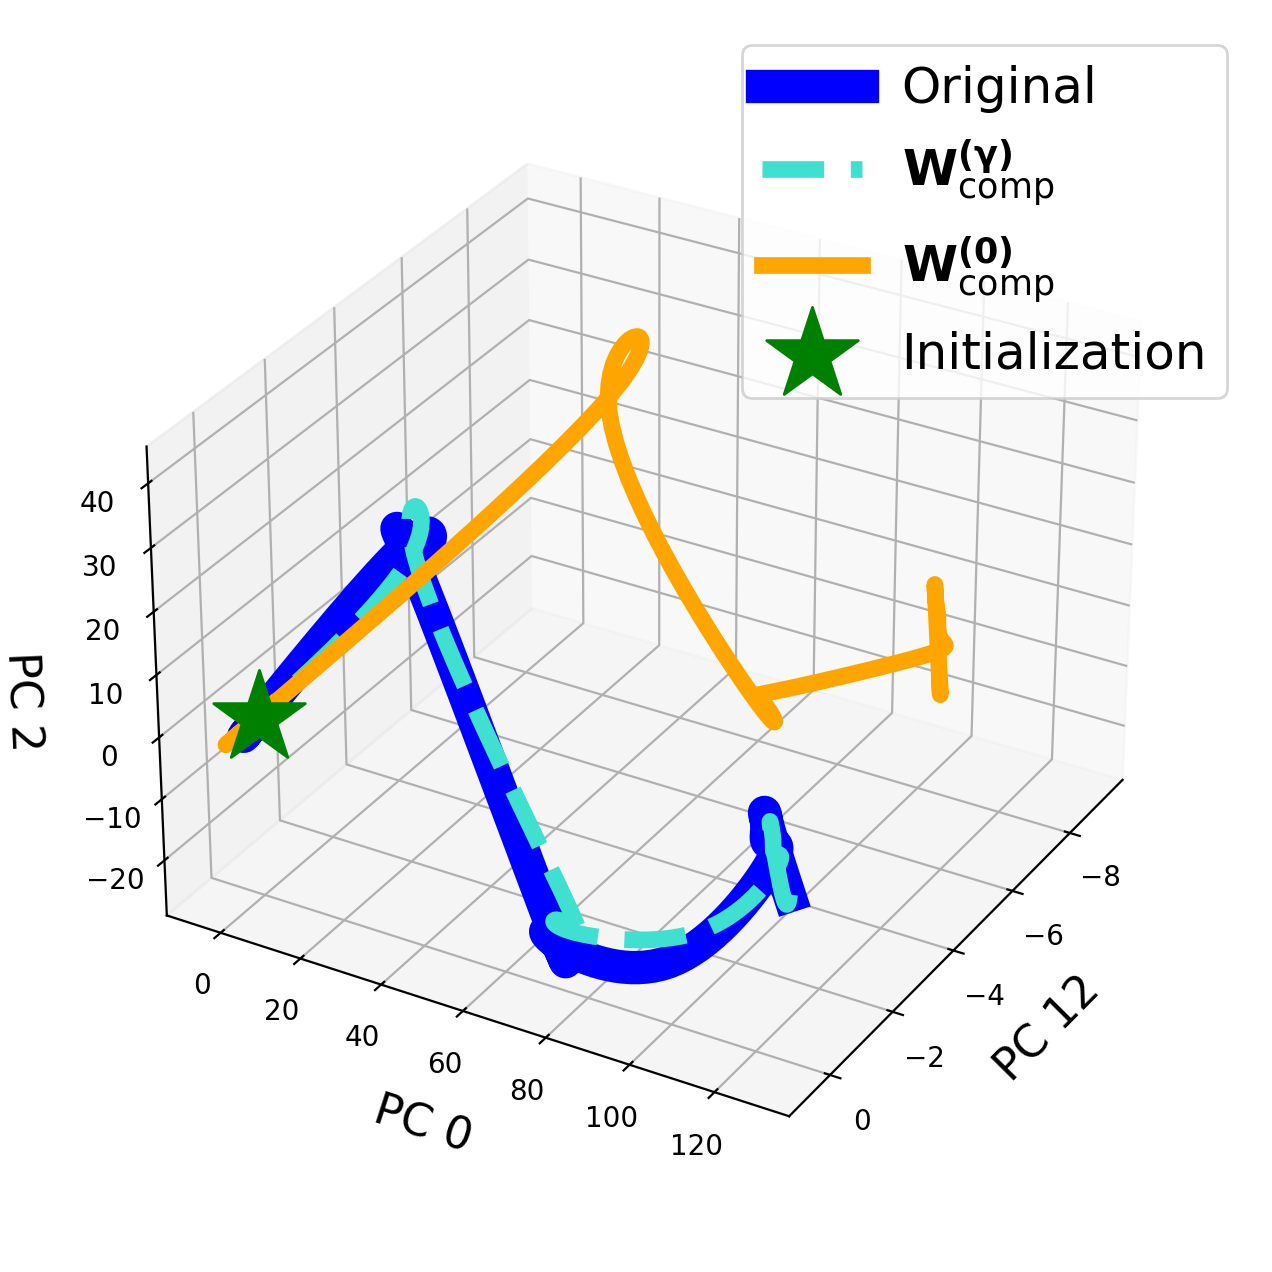

In [22]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection='3d')
ax.plot(red_orig_end_to_end[:, 0], red_orig_end_to_end[:, 1], red_orig_end_to_end[:, 2], linewidth=12, c='blue', linestyle='solid', label='Original')
ax.plot(red_comp_end_to_end[:, 0], red_comp_end_to_end[:, 1], red_comp_end_to_end[:, 2], linewidth=6, c='turquoise', linestyle='dashed', label=r'$\bf{W}^{(\gamma)}_{\mathrm{comp}}$')
ax.plot(red_no_dlr_end_to_end[:, 0], red_no_dlr_end_to_end[:, 1], red_no_dlr_end_to_end[:, 2], linewidth=6, c='orange', linestyle='solid', label=r'$\bf{W}^{(0)}_{\mathrm{comp}}$')
ax.scatter(red_comp_end_to_end[0, 0], red_comp_end_to_end[0, 1], red_comp_end_to_end[0, 2], s=1200, c='green', marker='*', label='Initialization')
elev = 30
azim = 30
roll = 0

ax.legend(fontsize=18)
ax.set_box_aspect(None, zoom=0.9)

ax.set_xlabel('\nPC 12', fontsize=16)
ax.set_ylabel('\nPC 0', fontsize=16)
ax.set_zlabel('\nPC 2', fontsize=16)
ax.view_init(elev, azim, roll)

# plt.savefig('figs/equiv_traj_mc_left.png', dpi=300, bbox_inches='tight')

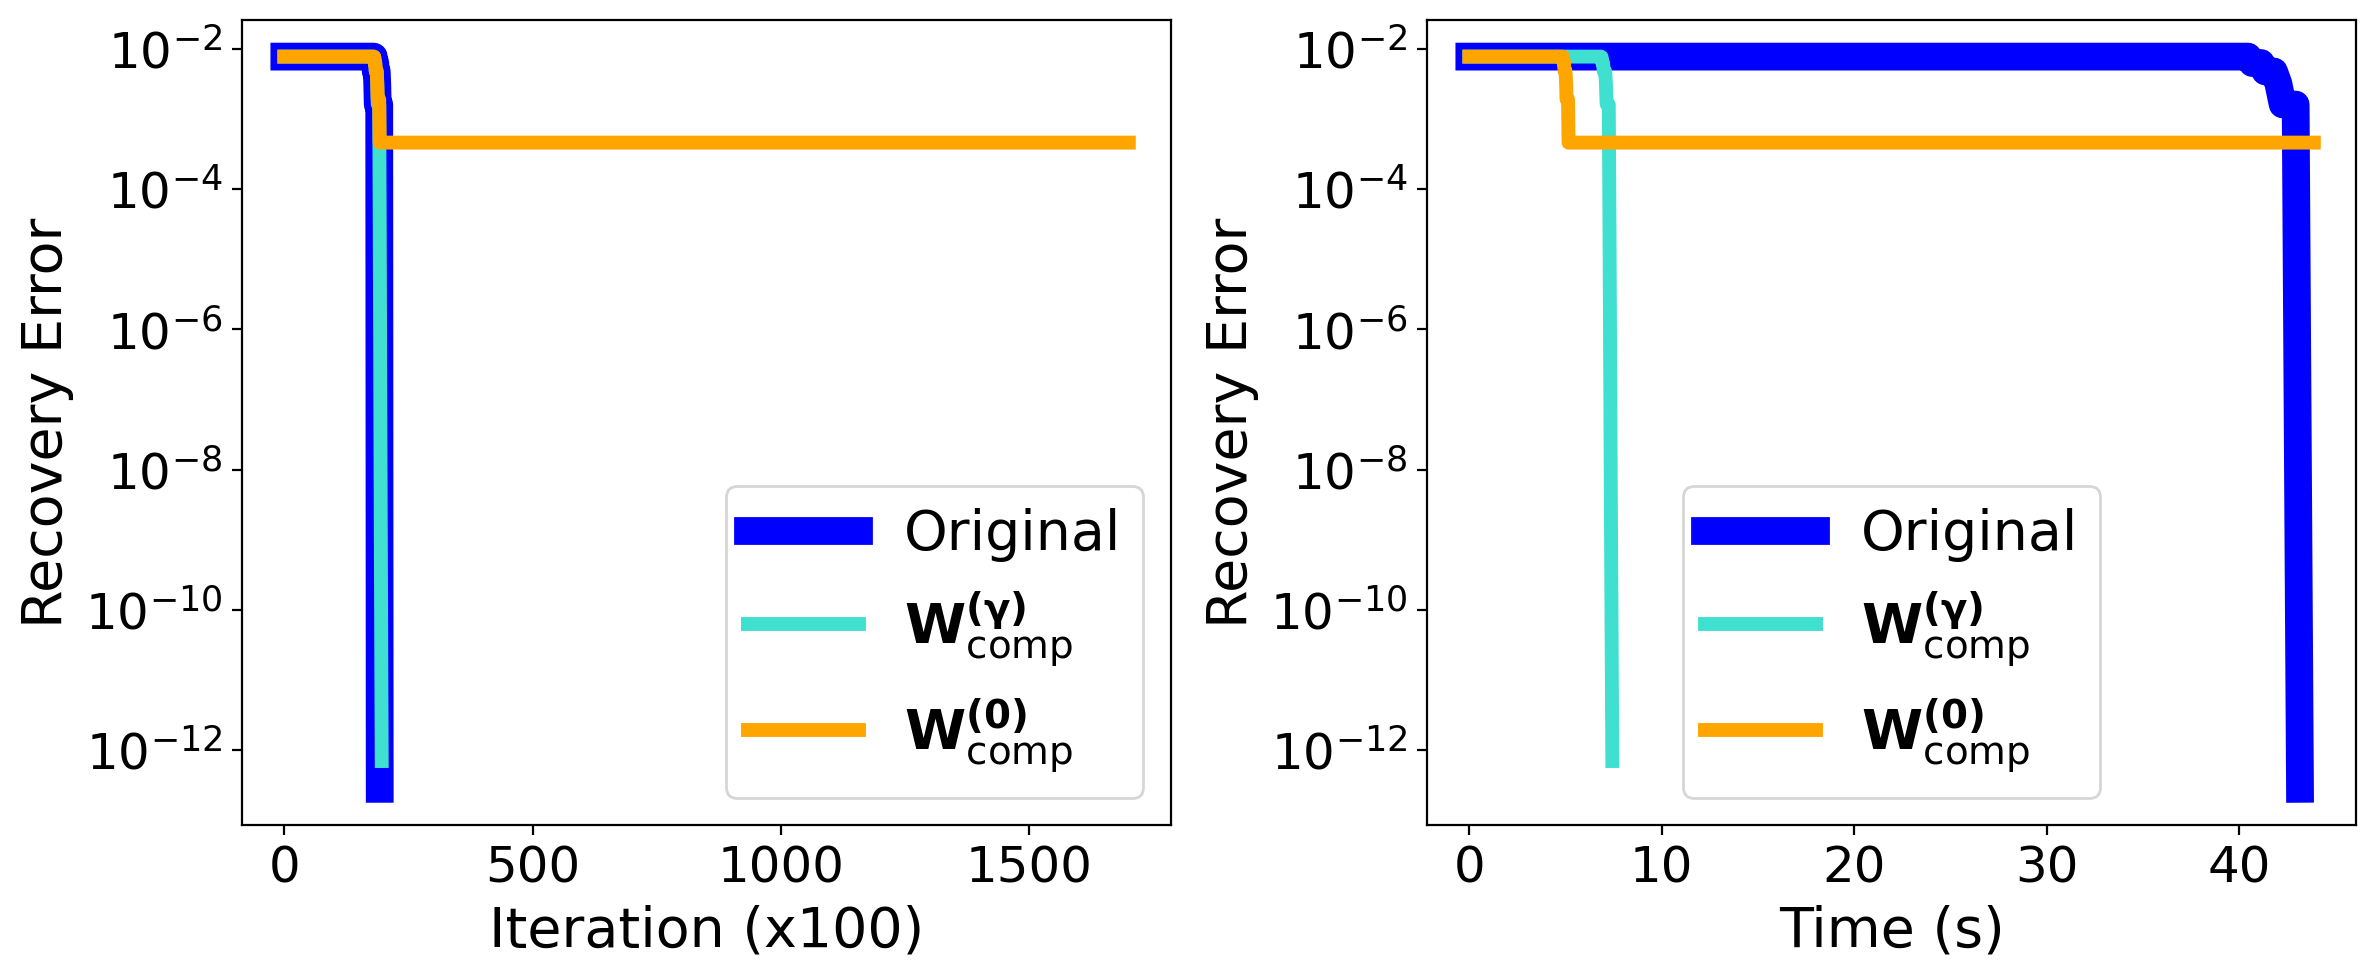

In [23]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121)

ax.semilogy(orig_result['test_loss'], c='blue', linewidth=10, label='Original')
ax.semilogy(comp_result['test_loss'], c='turquoise', linewidth=5, label=r'$\bf{W}^{(\gamma)}_{\mathrm{comp}}$')
ax.semilogy(no_dlr_result['test_loss'], c='orange', linewidth=5, label=r'$\bf{W}^{(0)}_{\mathrm{comp}}$')
ax.set_xlabel('Iteration (x100)', fontsize=20)
ax.set_ylabel('Recovery Error', fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)

ax = fig.add_subplot(122)

ax.semilogy(orig_result['time'], orig_result['test_loss'], c='blue', linewidth=10, label='Original')
ax.semilogy(comp_result['time'], comp_result['test_loss'], c='turquoise', linewidth=5, label=r'$\bf{W}^{(\gamma)}_{\mathrm{comp}}$')
ax.semilogy(no_dlr_result['time'], no_dlr_result['test_loss'], c='orange', linewidth=5, label=r'$\bf{W}^{(0)}_{\mathrm{comp}}$')
ax.set_xlabel('Time (s)', fontsize=20)
ax.set_ylabel('Recovery Error', fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)

fig.tight_layout()

# plt.savefig('figs/equiv_traj_mc_right.png', dpi=500, bbox_inches='tight')

In [17]:
from PIL import Image

image1 = Image.open('figs/equiv_traj_mc_left.png')
image2 = Image.open('figs/equiv_traj_mc_right.png')

(width1, height1) = image1.size
(width2, height2) = image2.size

ratio = height1 / height2

image2 = image2.resize(size=(int(width2 * ratio), int(height2 * ratio)))
(width2, height2) = image2.size

result_width = width1 + width2
result_height = height1

result = Image.new('RGB', (result_width, result_height))
result.paste(im=image1, box=(0, 0))
result.paste(im=image2, box=(width1, 0))

result.save('figs/equiv_traj_mc.png')

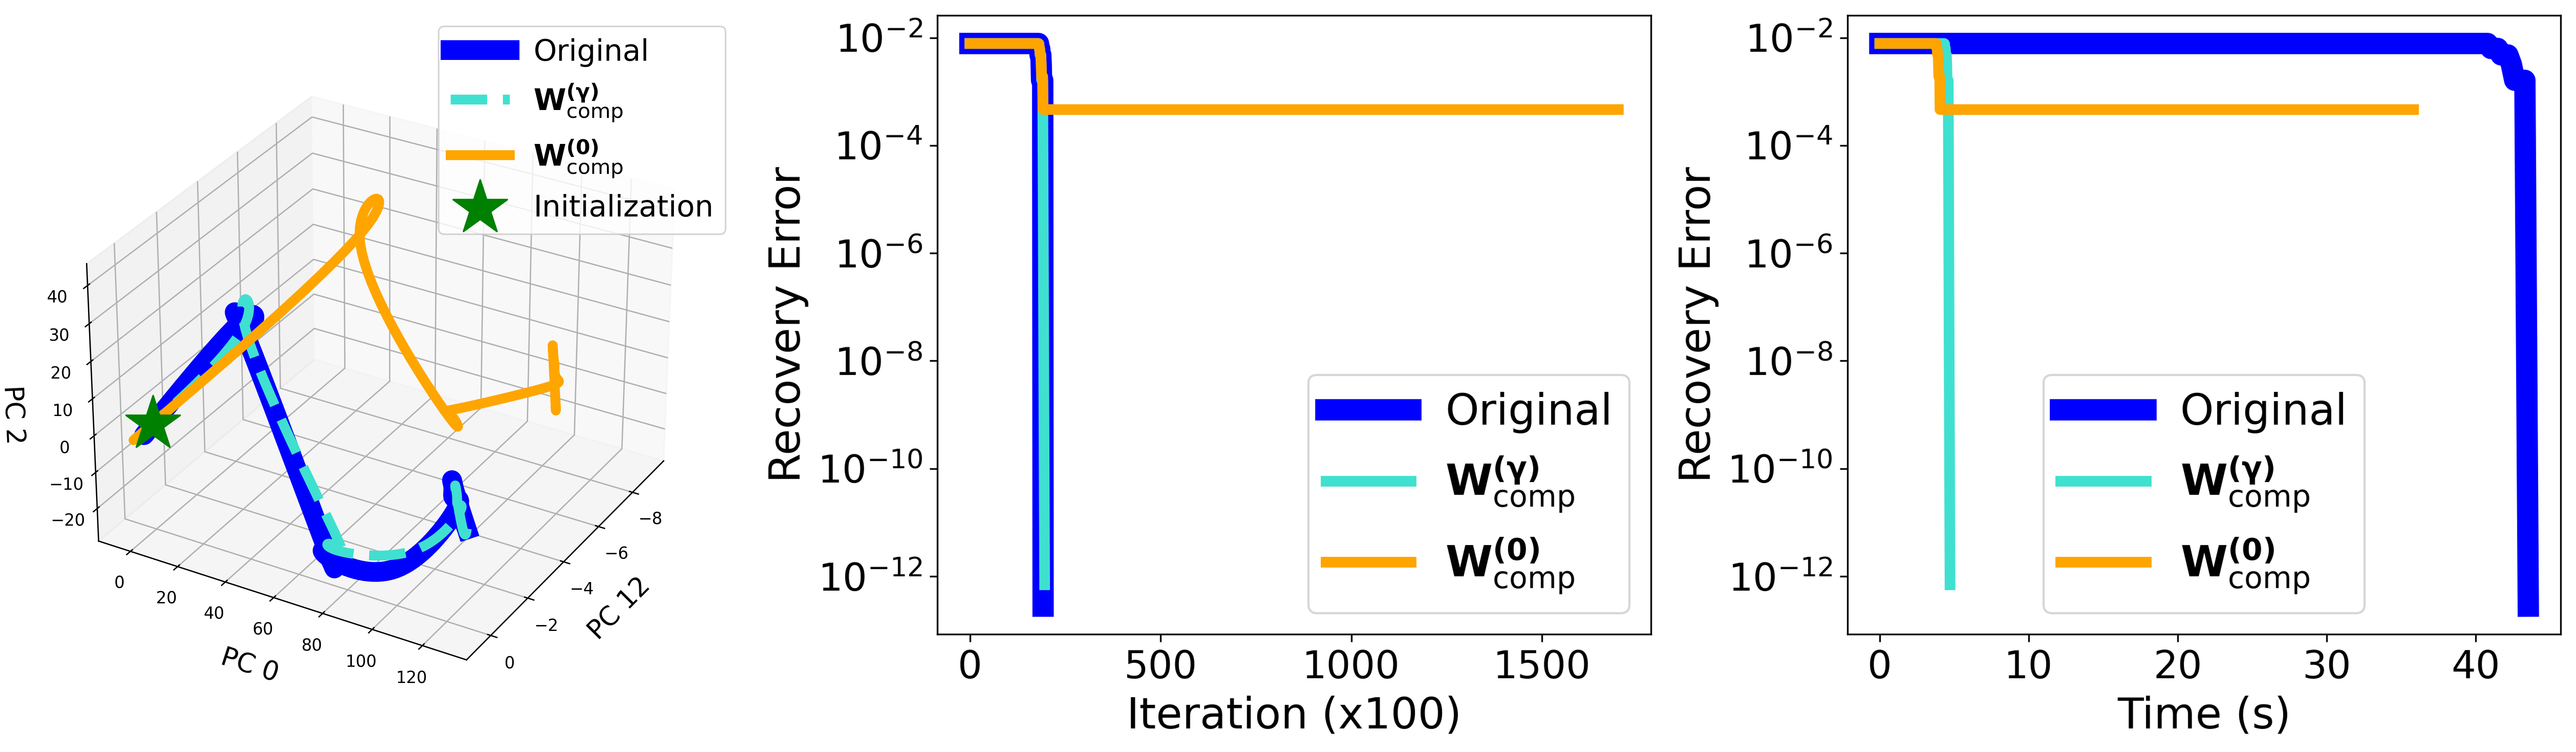

In [13]:
result